# INDIVIDUAL PLANNING STAGE:

The dataset players.csv consists of the name, Age, and gender of the player, whether or not theyre subscribed, their hashedEmail, their experience, and the number of hours they played (played_hours). 
- It has 196 different players recorded.

The dataset sessions.csv consists of each session every student played, so it has the hashed email, the start and end time of their session in a proper date/time format, and the Epoch unix time stamp in the form of 1.XXXXXE+12, which is the number of seconds from January 1, 1970. 
- After looking at the data, it has 1535 different sessions

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)



── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
players <- read_csv("players.csv")
players
sessions <- read_csv("sessions.csv")
sessions

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


A question that seems interesting to answer is to see what time windows are most likely to have large number of simultaneous players. And more specifically, if we can predict what time someone from a certain age group is more likely to play at.

So for example, for the age groups 8-17 (students in school), when are they most likely to play? What about 18-23 (uni student)? 24-29. Can we see a trend at all? Id like to initially assume that 4:30-5pm might have the highest amount of school students (school tends to end at 3:00, so theyd need approx 1.5hr to go home and eat), and i'd like to answer that question here.

The variables with numeric values are already in dbl data type, while everything else is a chr (except for the subscribe column), so this will make it easier to work on this data. It might be useful later on to change gender and experience into factors to make it easier to visualize the data later on, but we'll have to see later. An issue i currently see is that im not exactly sure how to work with the start_time and end_time variables in the sessions.csv data, so to test it out, ill write a quick code and see what happens.


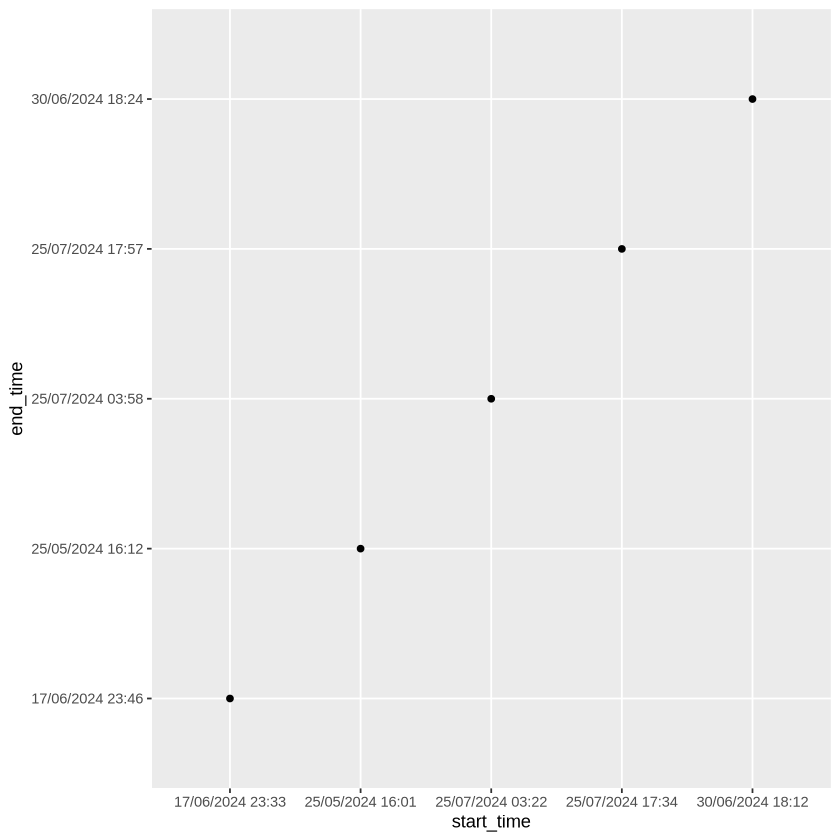

In [3]:
test_graph <- sessions |>
    head(5) |>
    ggplot(aes(x = start_time, y = end_time)) +
        geom_point()

test_graph

I can already see that a scatter plot will not work, so we'll probably need a histogram, where the x axis is the time (so for example, each bin is 30 min, so the bins can be for example 16:00-16:30, then 16:30-17:00, and so on.), and the y axis is the total count of players during that time. And then we can have a fill for each age group.

However, one main issue i see is that the sessions.csv dataset does not have the ages of the players, its only in the players.csv file. However, both files have the hashedEmail variable, so if we can somehow join both datasets together and replace the hashed emails with the ages, then this can work. additionally, we're gonna have to somehow 
